## import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080


## load data

In [3]:
xy = pd.read_csv('../data/tr.csv')
xy

,date,new_cases,total_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index
0,2020-01-21,0,0,0.000,0,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
1,2020-01-22,0,1,0.000,0,0,0.000,0.020,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
2,2020-01-23,0,1,0.000,0,0,0.000,0.020,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
3,2020-01-24,1,2,0.000,0,0,0.000,0.039,0.020,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
4,2020-01-25,0,2,0.000,0,0,0.000,0.039,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,2021-06-22,644,152545,479.143,2007,1,2.000,2975.374,12.561,9.346,...,18267181.0,15098865.0,4292272.0,180979.0,300142.0,35.63,29.45,8.37,5854.0,50.0
519,2021-06-23,610,153155,489.143,2008,1,2.000,2987.272,11.898,9.541,...,18438254.0,15150121.0,4413494.0,171073.0,276269.0,35.96,29.55,8.61,5389.0,50.0
520,2021-06-24,634,153789,507.286,2009,1,1.857,2999.638,12.366,9.895,...,18595784.0,15199919.0,4521785.0,157530.0,247258.0,36.27,29.65,8.82,4823.0,50.0
521,2021-06-25,668,154457,533.857,2012,3,2.143,3012.667,13.029,10.413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## data information

In [4]:
xy = xy.interpolate()
xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   523 non-null    object 
 1   new_cases                              523 non-null    int64  
 2   total_cases                            523 non-null    int64  
 3   new_cases_smoothed                     523 non-null    float64
 4   total_deaths                           523 non-null    int64  
 5   new_deaths                             523 non-null    int64  
 6   new_deaths_smoothed                    523 non-null    float64
 7   total_cases_per_million                523 non-null    float64
 8   new_cases_per_million                  523 non-null    float64
 9   new_cases_smoothed_per_million         523 non-null    float64
 10  total_deaths_per_million               523 non-null    float64
 11  new_de

## hyper parameter

In [5]:
seq_length = 5              # 5 일치의 데이터 입력
data_dim = len(xy.iloc[0])-1# feature 개수
hidden_dim = 15
output_dim = 1
learning_rate = 0.001
epoch = 300
train_size = int(len(xy) * 0.8)

## Scaling

In [6]:
scaler = MinMaxScaler()
origin_scale = xy.iloc[:, [1]].to_numpy()

# 입력변수를 MinMaxScaling 하기
xy.iloc[:,1:] = scaler.fit_transform(xy.iloc[:,1:])

## result of scaling & train/test_set

In [7]:
# train set과 test set 나누기
train_size = int(len(xy) * 0.8)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]
test_set

,date,new_cases,total_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index
413,2021-03-09,0.379951,0.604452,0.397845,0.818679,0.075,0.219514,0.604452,0.379932,0.397846,...,0.024035,0.029404,0.000000,0.060019,0.070877,0.023987,0.029342,0.00000,0.070893,0.707802
414,2021-03-10,0.375909,0.607451,0.403436,0.820666,0.100,0.201204,0.607451,0.375912,0.403426,...,0.026922,0.032937,0.000000,0.050675,0.068255,0.027020,0.033052,0.00000,0.068275,0.707802
415,2021-03-11,0.394503,0.610598,0.415712,0.825633,0.250,0.213411,0.610598,0.394479,0.415712,...,0.029376,0.035939,0.000000,0.043076,0.063171,0.029501,0.036088,0.00000,0.063181,0.707802
416,2021-03-12,0.396120,0.613758,0.425668,0.828117,0.125,0.213411,0.613758,0.396096,0.425649,...,0.031387,0.038399,0.000000,0.035279,0.056637,0.031431,0.038449,0.00000,0.056601,0.707802
417,2021-03-13,0.371059,0.616718,0.431533,0.829111,0.050,0.213411,0.616718,0.371063,0.431522,...,0.031614,0.038677,0.000000,0.003988,0.053867,0.031707,0.038786,0.00000,0.053842,0.707802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,2021-06-22,0.520614,0.983711,0.457447,0.997019,0.025,0.085364,0.983711,0.520598,0.457465,...,0.982329,0.993352,0.949243,0.170803,0.414205,0.982355,0.993255,0.94898,0.414179,0.606722
519,2021-06-23,0.493129,0.987644,0.466994,0.997516,0.025,0.085364,0.987644,0.493120,0.467009,...,0.991529,0.996724,0.976051,0.161454,0.381260,0.991453,0.996627,0.97619,0.381279,0.606722
520,2021-06-24,0.512530,0.991733,0.484315,0.998013,0.025,0.079261,0.991733,0.512517,0.484337,...,1.000000,1.000000,1.000000,0.148672,0.341224,1.000000,1.000000,1.00000,0.341234,0.606722
521,2021-06-25,0.540016,0.996041,0.509683,0.999503,0.075,0.091468,0.996041,0.539995,0.509692,...,1.000000,1.000000,1.000000,0.148672,0.341224,1.000000,1.000000,1.00000,0.341234,0.606722


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 413 to 522
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   110 non-null    object 
 1   new_cases                              110 non-null    float64
 2   total_cases                            110 non-null    float64
 3   new_cases_smoothed                     110 non-null    float64
 4   total_deaths                           110 non-null    float64
 5   new_deaths                             110 non-null    float64
 6   new_deaths_smoothed                    110 non-null    float64
 7   total_cases_per_million                110 non-null    float64
 8   new_cases_per_million                  110 non-null    float64
 9   new_cases_smoothed_per_million         110 non-null    float64
 10  total_deaths_per_million               110 non-null    float64
 11  new_

## dataset function

In [9]:
def sliding_windows(time_series, seq_length, day):
    dataX = []
    dataY = []
    for i in range(len(time_series) - seq_length - day+1):
        _x = time_series.iloc[i:i+seq_length, 1:]
        _y = time_series.iloc[i+seq_length+day-1, [1]]
        print(_x, '->', _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY, dtype=float)

## build dataset

In [10]:
trainX, trainY = sliding_windows(train_set, seq_length, 7)
testX, testY = sliding_windows(test_set, seq_length, 7)

   new_cases  total_cases  new_cases_smoothed  total_deaths  new_deaths  \
0   0.000000     0.000000                 0.0           0.0         0.0   
1   0.000000     0.000006                 0.0           0.0         0.0   
2   0.000000     0.000006                 0.0           0.0         0.0   
3   0.000808     0.000013                 0.0           0.0         0.0   
4   0.000000     0.000013                 0.0           0.0         0.0   

   new_deaths_smoothed  total_cases_per_million  new_cases_per_million  \
0                  0.0                 0.000000               0.000000   
1                  0.0                 0.000007               0.000000   
2                  0.0                 0.000007               0.000000   
3                  0.0                 0.000013               0.000829   
4                  0.0                 0.000013               0.000000   

   new_cases_smoothed_per_million  total_deaths_per_million  ...  \
0                             0.0   

### array -> tensor

In [11]:
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)
testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

# RNN

In [12]:
class Net(nn.Module):
    def __init__(self, data_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.rnn = nn.RNN(data_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

net = Net(data_dim, hidden_dim, output_dim).to(device)

# loss & optimizer setting
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate) # 0.001

### Learning

In [13]:
from tqdm import tqdm
for i in tqdm(range(epoch)):
    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()

100%|██████████| 300/300 [00:00<00:00, 821.57it/s]


In [14]:
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(origin_scale)
inverse_x = inverse_scaler.inverse_transform(net(testX_tensor).cpu().detach().numpy())
inverse_y = inverse_scaler.inverse_transform(testY)

# day 7

In [15]:
Date = xy.iloc[:,0]
date = Date.iloc[train_size+6:]

In [16]:
# plt.plot(inverse_y, label = 'predict')
# plt.show()

/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49483 (\N{HANGUL SYLLABLE SES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.l

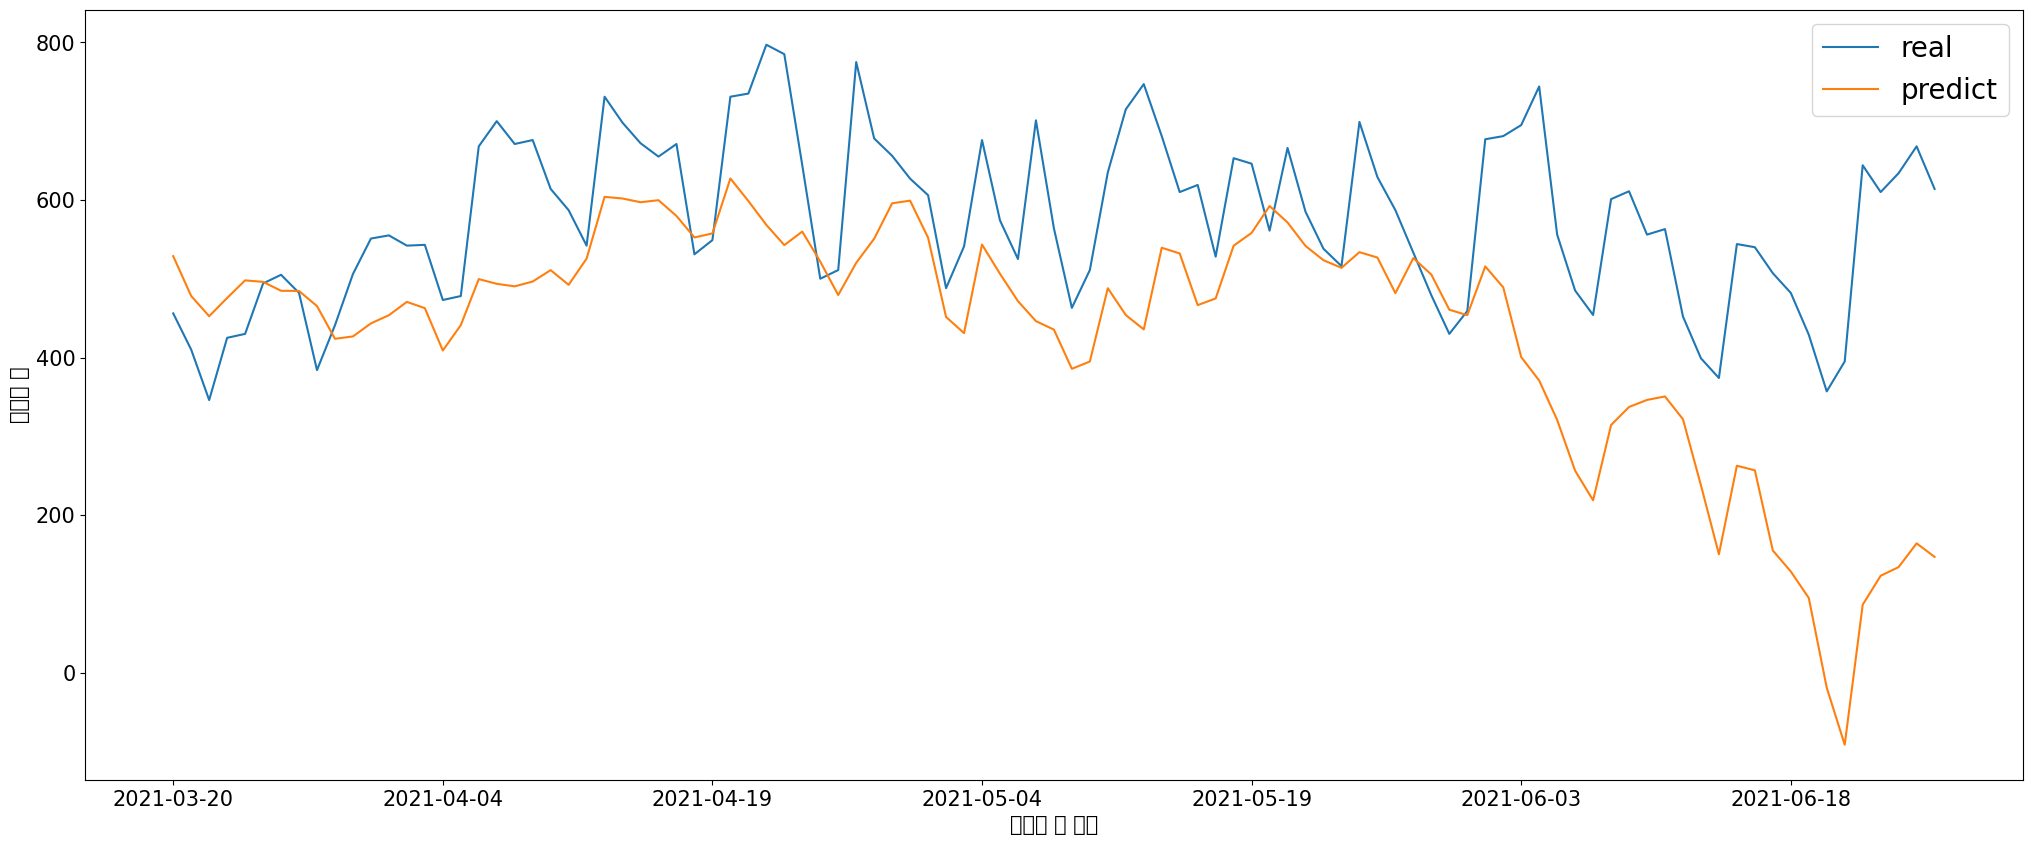

In [17]:
plt.rc('font', size=15) # font가 지정되어 있다면 한글 출력 가능
plt.figure(figsize=(25,10))
plt.plot(inverse_y, label = 'real')
plt.plot(date, inverse_x, label = 'predict')
plt.xticks(range(0, len(inverse_y), 15))
plt.xlabel('테스트 셋 일자')
plt.ylabel('확진자 수')
plt.rc('legend', fontsize = 20)
plt.legend()
plt.show()

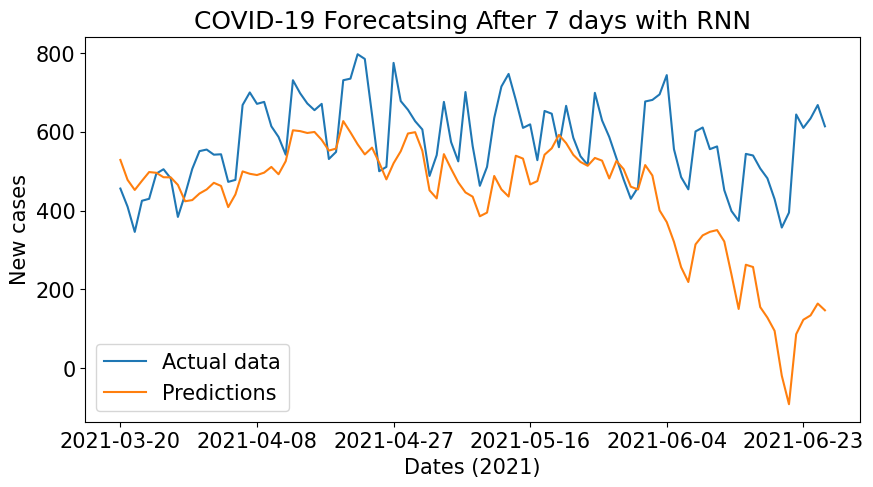

In [18]:
plt.rc('font', size=15)
plt.figure(figsize=(10,5))
plt.plot(inverse_y, label = 'Actual data')
plt.plot(date, inverse_x, label = "Predictions")
plt.xticks(np.arange(0,len(inverse_y), 19))
plt.title('COVID-19 Forecatsing After 7 days with RNN')
plt.xlabel('Dates (2021)')
plt.ylabel('New cases')
plt.rc('legend', fontsize = 15)
plt.legend()
plt.show()

### train_set의 학습 그래프

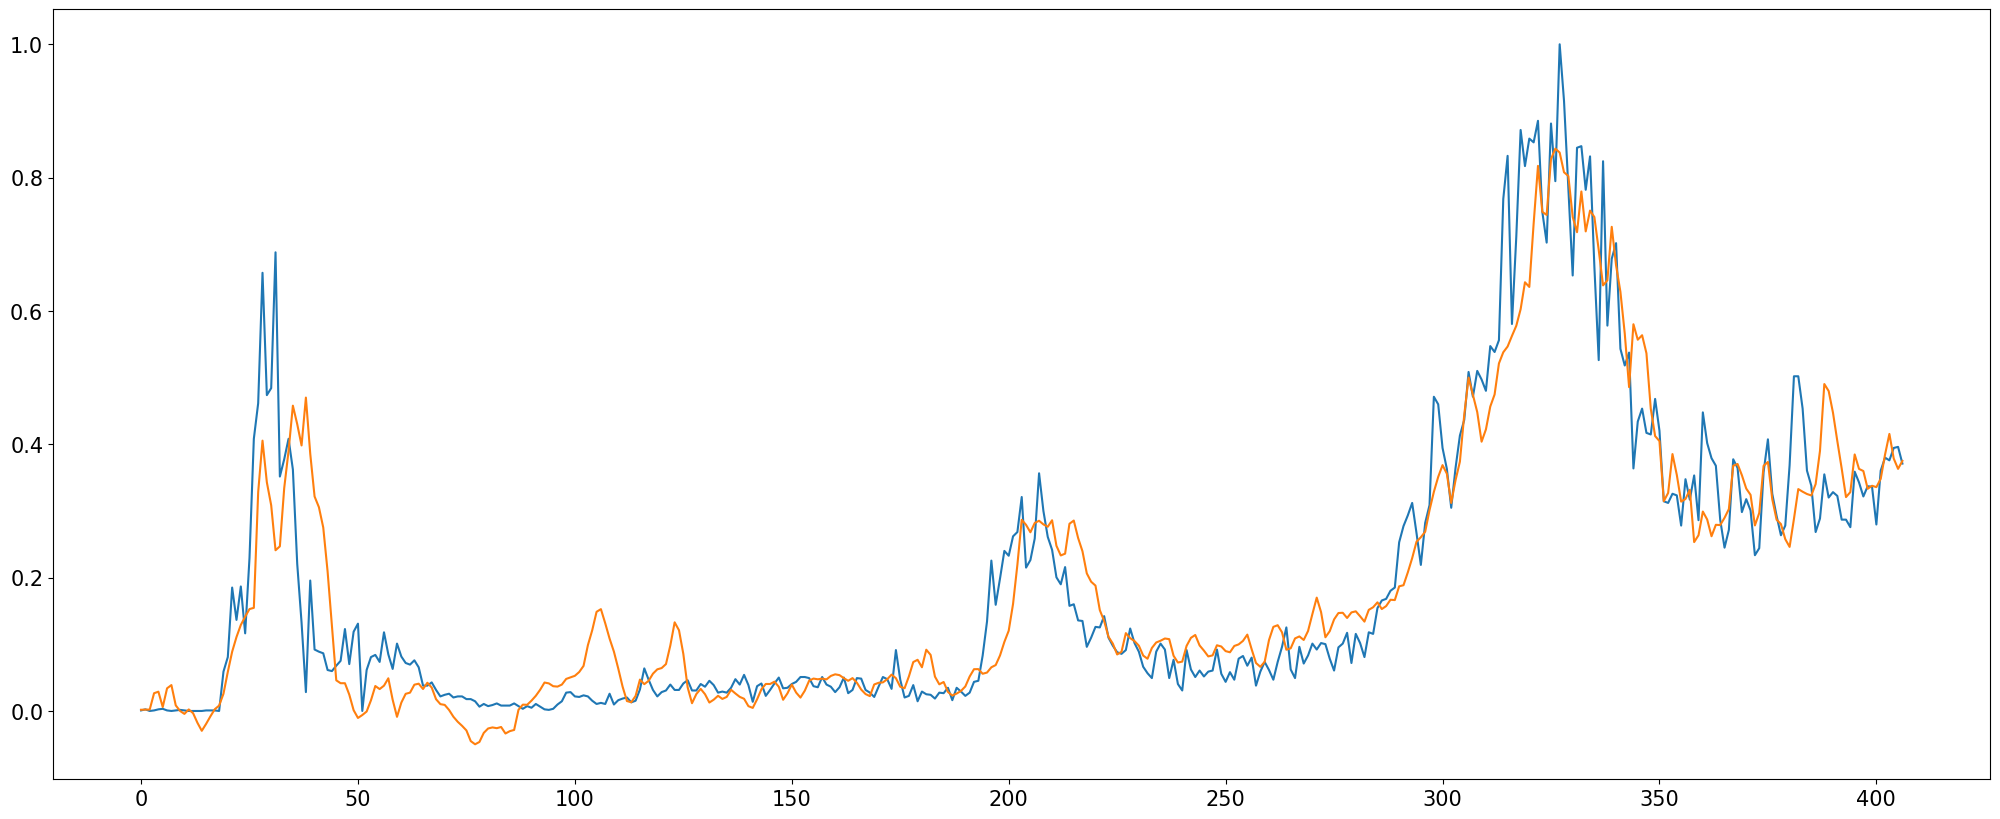

In [19]:
plt.figure(figsize=(25,10))
plt.plot(trainY)
plt.plot(net(trainX_tensor).cpu().data.numpy())
plt.show()

### RMSE 구하기

In [20]:
def rmse(pred, real):
    E = pred-real
    SE = []
    for i in E:
        SE.append(i**2)
    MSE = sum(SE)/len(SE)
    RMSE = MSE**0.5
    return RMSE


print(f'RMSE : {rmse(inverse_x.flatten(), inverse_y.flatten())}')

RMSE : 199.4273892761327
